# Starting Point
In `1. Toxic Comment Classification - EDA` I did some quick EDA of Kaggles [Toxic Comment Classification](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge) data set.
The dataset includes thousands of comments made on Wikipedia by it's editors, classified as one or more types of toxicity: toxic, severe_toxic, obscene, threat, insult or identity_hate.

As expected from these kind of texts, the language is very varied. 
Some comment's are entirely written in ALL CAPS, some are nicely formatted and some are poorly spelled. 
The comments also vary a lot in length, with the average comment being about 80 word tokens long.

It's probably possible to construct powerful handcarfted features based on further EDA, but first let's see what we can achieve with some classification models without applying any handcrafted features.

# Baseline Model
In this notebook I will recast the problem of classifying a comment as one or more kind of toxicity type to that of simply detecting if it is toxic at all, i.e. a binary classification problem on `{clean, toxic}`.

I will first tackle this with a simple tf-idf + bag of word model.

# Data Processing
I will apply some of the tricks I used in my previous notebook:
* Expanding contracted words like `I'm` to `I am`
* Tokenizing with nltk

I will also convert all words to lower case.

After that I will calculate weights for each token using tf-idf, and lastly I will represent each comment with a bag of words model.

## Read and filter data

As I am recasting the problem from the original challenge I have no use for the unlabeled test set.

In [1]:
import pandas as pd

data = pd.read_csv('data/train.csv')

In [2]:
print("There are %d comments that are neither clean, nor toxic." % len(data.loc[~data['toxic'] & data.iloc[:,3:].any(1)]))

There are 931 comments that are neither clean, nor toxic.


Remove all comments that are neither clean nor toxic.

In [3]:
data = data.loc[data['toxic'] | ~data.iloc[:,2:].any(1)]

Drop all columns except for text and label.

In [4]:
data = data.loc[:,['comment_text', 'toxic']]

## Pre process data

In [5]:
# List from https://drive.google.com/file/d/0B1yuv8YaUVlZZ1RzMFJmc1ZsQmM/view
contractions = {
    "aren't" : "are not",
    "can't" : "cannot",
    "couldn't" : "could not",
    "didn't" : "did not",
    "doesn't" : "does not",
    "don't" : "do not",
    "hadn't" : "had not",
    "hasn't" : "has not",
    "haven't" : "have not",
    "he'd" : "he would",
    "he'll" : "he will",
    "he's" : "he is",
    "i'd" : "I would",
    "i'd" : "I had",
    "i'll" : "I will",
    "i'm" : "I am",
    "isn't" : "is not",
    "it's" : "it is",
    "it'll":"it will",
    "i've" : "I have",
    "let's" : "let us",
    "mightn't" : "might not",
    "mustn't" : "must not",
    "shan't" : "shall not",
    "she'd" : "she would",
    "she'll" : "she will",
    "she's" : "she is",
    "shouldn't" : "should not",
    "that's" : "that is",
    "there's" : "there is",
    "they'd" : "they would",
    "they'll" : "they will",
    "they're" : "they are",
    "they've" : "they have",
    "we'd" : "we would",
    "we're" : "we are",
    "weren't" : "were not",
    "we've" : "we have",
    "what'll" : "what will",
    "what're" : "what are",
    "what's" : "what is",
    "what've" : "what have",
    "where's" : "where is",
    "who'd" : "who would",
    "who'll" : "who will",
    "who're" : "who are",
    "who's" : "who is",
    "who've" : "who have",
    "won't" : "will not",
    "wouldn't" : "would not",
    "you'd" : "you would",
    "you'll" : "you will",
    "you're" : "you are",
    "you've" : "you have",
    "'re": " are",
    "wasn't": "was not",
    "we'll":" will",
    "didn't": "did not"
}

def expand_contractions(text):
    text = text.split(" ")
    text = [contractions[word] if word in contractions else word for word in text]
    return " ".join(text)

def process_sentence(sentence):
    sentence = sentence.lower()
    sentence = expand_contractions(sentence)
    return sentence

## Set aside test and validation set
Before applying any methods that are tuned to the data set I will set aside a test and validation set.

In [6]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(data, test_size=.3, random_state=0, stratify=data['toxic'])
train_df, val_df = train_test_split(train_df, test_size=.15, random_state=0, stratify=train_df['toxic'])

In [7]:
print("Training comments: %d" % len(train_df))
print("Validation comments: %d" % len(val_df))
print("Test comments: %d" % len(test_df))

Training comments: 94390
Validation comments: 16658
Test comments: 47592


## TF-IDF

### Count and filter words

First we convert each comment to a bag of words model. 
This means that every comment will be represented with a vector containing all it's word counts. 
I will exclude any word that appear in less than 10 documents, as well as words that appear in more than 95% of all documents.

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize

In [9]:
vectorizer = CountVectorizer(preprocessor = process_sentence, tokenizer=word_tokenize, max_df=.95, min_df=10)

In [10]:
train_counts = vectorizer.fit_transform(train_df['comment_text'])

In [11]:
import numpy as np

In [12]:
print("Each comment is now represented by a 1x%d word vector" % train_counts.shape[1])

Each comment is now represented by a 1x16882 word vector


### Convert word counts to weights using TF-IDF

In [13]:
from sklearn.feature_extraction.text import TfidfTransformer

We filtered out all words with document frequency less than 10, so we don't need to do any smoothing. 
All rows will be normalised to have unit L2 norm. 

In [14]:
tfidf = TfidfTransformer(smooth_idf=False, norm='l2')

In [15]:
X_train = tfidf.fit_transform(train_counts)
y_train = train_df['toxic'].values

## Process validation set and test set

In [16]:
def process_test(df, vectorizer, tfidf):
    word_counts = vectorizer.transform(df['comment_text'])
    return tfidf.transform(word_counts), df['toxic']

In [17]:
X_val, y_val = process_test(val_df, vectorizer, tfidf)
X_test, y_test = process_test(test_df, vectorizer, tfidf)

# Classification

## Naive Bayes
As a baseline for my classification I will apply a naive bayes classifier.

In [18]:
from sklearn.naive_bayes import MultinomialNB

In [19]:
naive_bayes = MultinomialNB()

In [20]:
naive_bayes.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [61]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('whitegrid')
%matplotlib inline

In [23]:
proba = naive_bayes.predict_proba(X_train)

In [62]:
def evaluate_model(X, y, model, axs, plot_pr_curve = True):
    
    ax = axs[0]
    pred = model.predict(X)
    
    conf = confusion_matrix(y, pred)
    conf_df = pd.DataFrame(data=conf, columns=['Clean', 'Toxic'], index=['Clean', 'Toxic'])
    sns.heatmap(conf_df, annot=True, cmap="YlGnBu", fmt='d', ax=ax, square=True, cbar=False)
    ax.set_ylabel('Target')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix (Decision Threshold = 0.5)')
    
    ax = axs[1]
    
    if plot_pr_curve:
        proba = model.predict_proba(X)
        proba = proba[:,1]
        precision, recall, thresholds = precision_recall_curve(y, proba)
        aps = average_precision_score(y, proba)
        idx = np.argmax(thresholds >= .5)
        ax.scatter(recall, precision, s=1)
        ax.scatter(recall[idx], precision[idx], s=100, marker='*', color='r')
        ax.legend(['PR Curve', 'Decision Threshold = 0.5'])
        ax.axis('equal')
        ax.set_ylabel('Precision')
        ax.set_xlabel('Recall')
        ax.set_title('Precision Recall Curve, APS = %.3f' % aps)
        
    else:
        precision = precision_score(y, pred)
        recall = recall_score(y, pred)
        df = pd.DataFrame([['Precision', precision], ['Recall', recall]], columns=['Metric', 'Score'])
        sns.barplot(x='Metric', y='Score', data=df, ax=ax)
        ax.set_title('Precision and Recall')
    

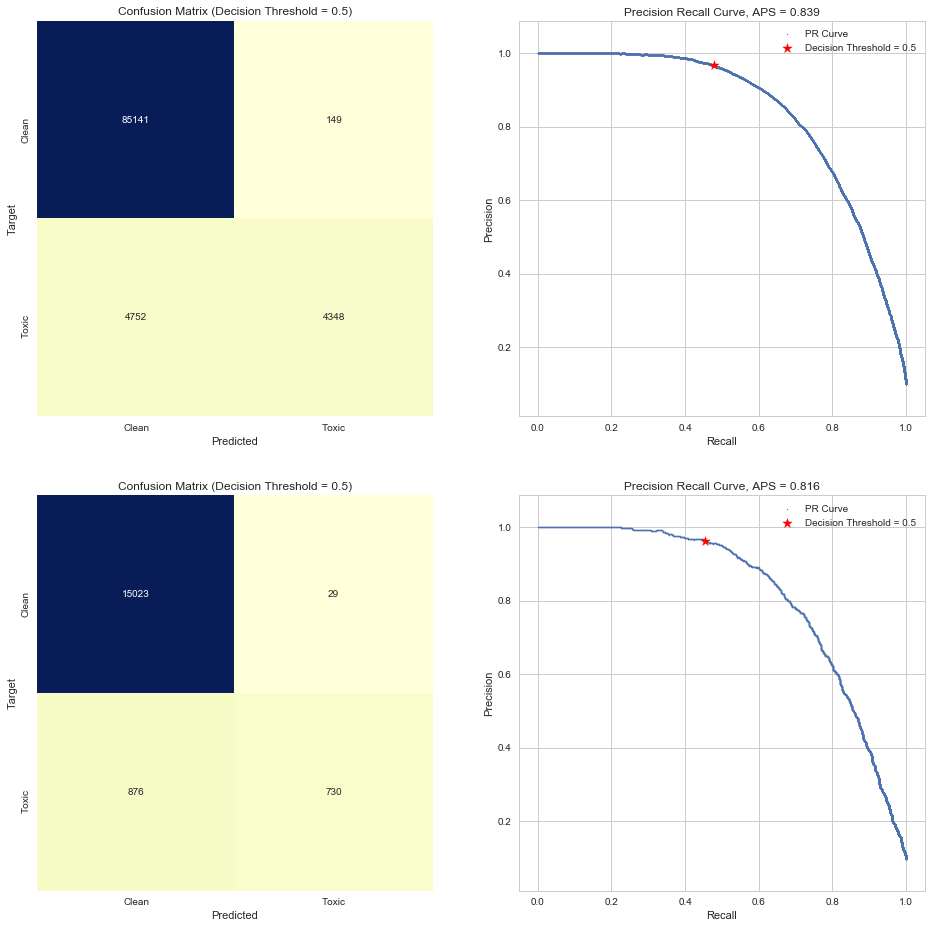

In [63]:
f, ax = plt.subplots(2, 2, figsize=(16,16))
evaluate_model(X_train, y_train, naive_bayes, ax[0])
evaluate_model(X_val, y_val, naive_bayes, ax[1])

The model obviously has a huge bias towards predicting comments as clean. There are very few false positives, ie clean comments predicted as toxic, Unfortunately more than half of the toxic comments are missclassified as clean.

By looking at the Precision-Recall Curve we can see that better recall could be achieved by shifting the decision threshold from 0.5 (50% certainty), but at the cost of precision.

## SVM

In [26]:
from sklearn.svm import LinearSVC

In [27]:
svm = LinearSVC()

In [28]:
svm.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

We don't have direct access to class probabilities with SVM, so here we just plot the Precision and Recall with 0.5 as our decision boundrary.

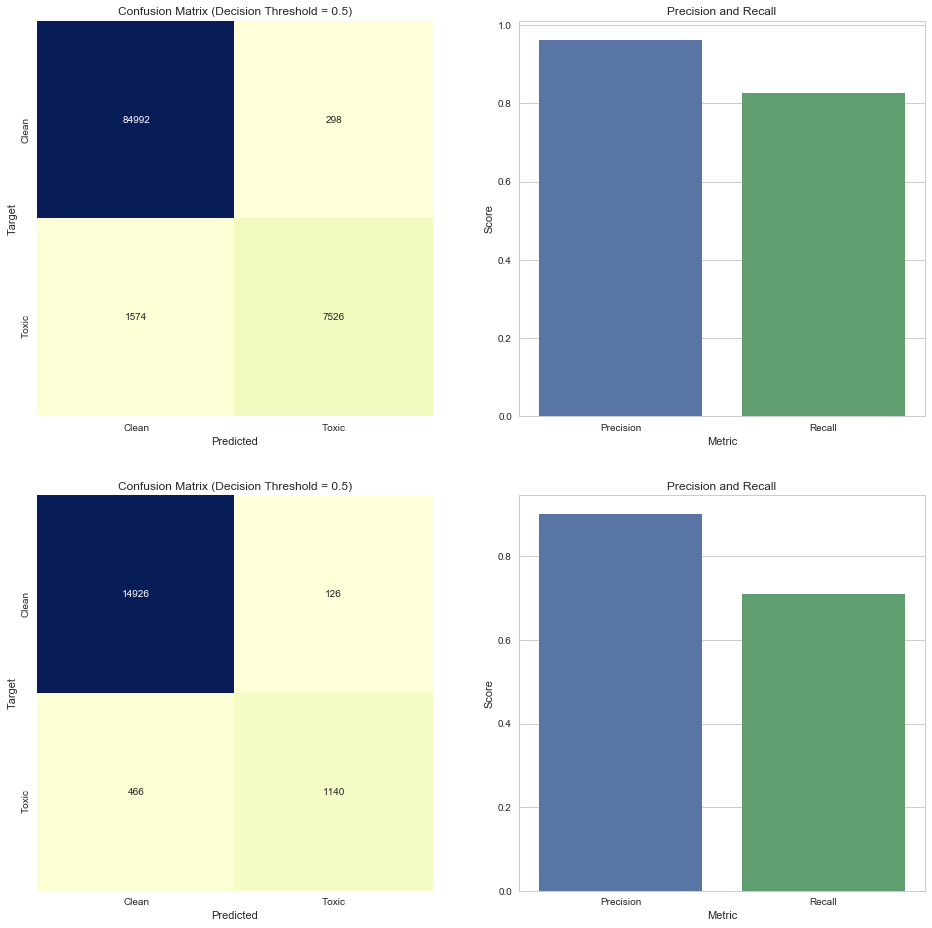

In [29]:
f, ax = plt.subplots(2, 2, figsize=(16,16))
evaluate_model(X_train, y_train, svm, ax[0], plot_pr_curve=False)
evaluate_model(X_val, y_val, svm, ax[1], plot_pr_curve=False)

Cool, we improved recall drastically compared to Naive Bayes, and the precision cost is not that bad.

## Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression

In [33]:
logistic_reg = LogisticRegression()

In [34]:
logistic_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

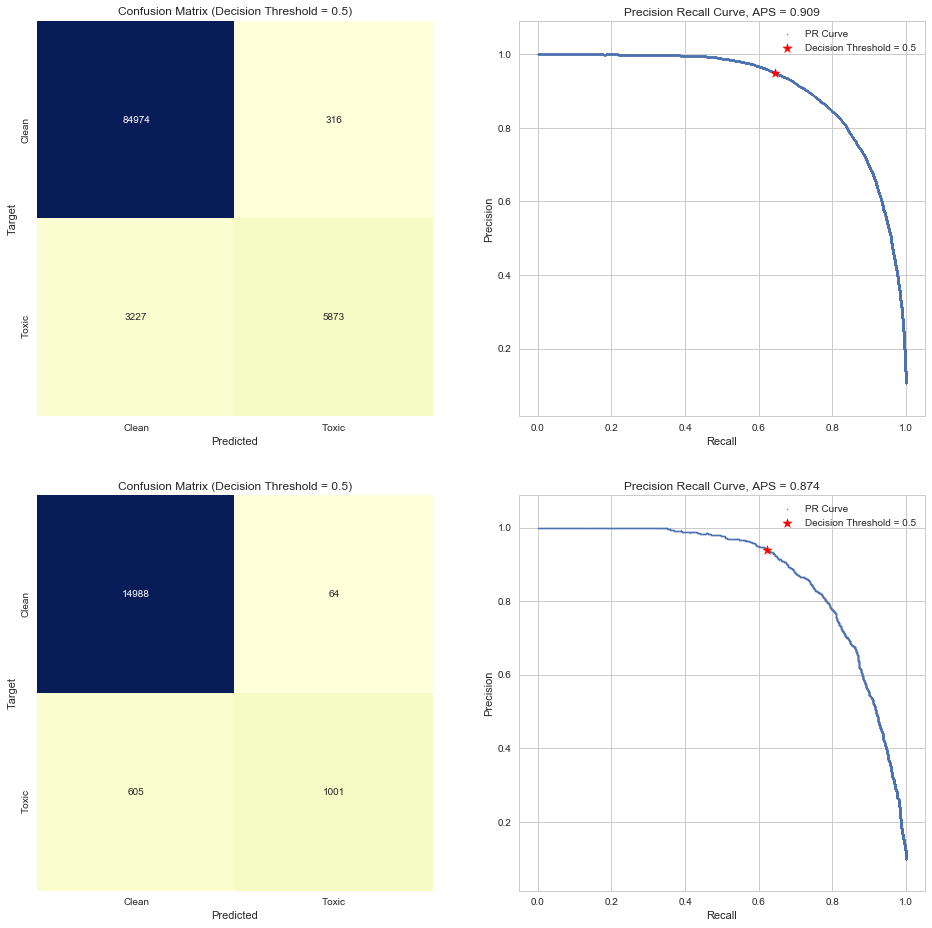

In [64]:
f, ax = plt.subplots(2, 2, figsize=(16,16))
evaluate_model(X_train, y_train, logistic_reg, ax[0])
evaluate_model(X_val, y_val, logistic_reg, ax[1])

Pretty big inrease in false positives now compared to SVM, but better precision on toxic. It's nice that I am able to compute the Average Precision Score, which is not easily available for SVM.

## Random Forest

In [65]:
from sklearn.ensemble import RandomForestClassifier

In [83]:
random_forest = RandomForestClassifier(n_estimators=400, min_samples_split=.05 , class_weight='balanced', random_state=0)

In [84]:
random_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=0.05, min_weight_fraction_leaf=0.0,
            n_estimators=400, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

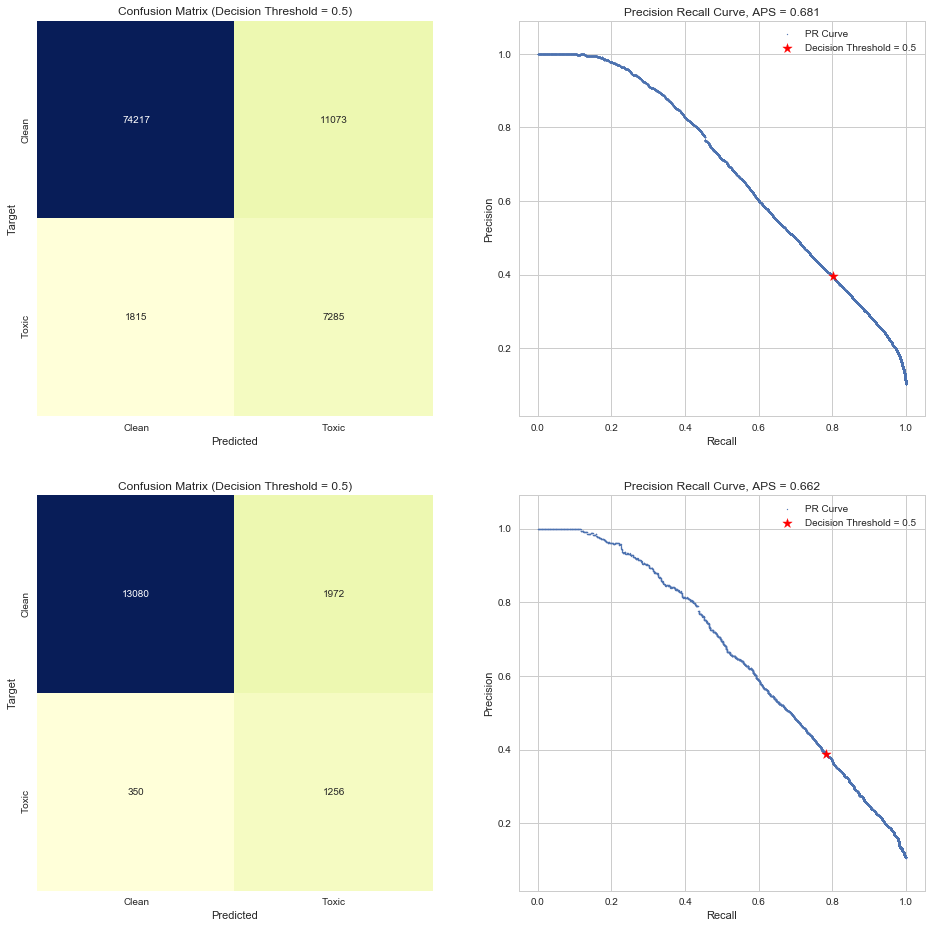

In [85]:
f, ax = plt.subplots(2, 2, figsize=(16,16))
evaluate_model(X_train, y_train, random_forest, ax[0])
evaluate_model(X_val, y_val, random_forest, ax[1])

My random forest performs worse than the Naive Bayes classifier. 
Perhaps because it requires more parameter tuning.
I went for many pretty shallow trees to avoid overfitting, but might have gone to far.

## LGBoost

In [86]:
from lightgbm.sklearn import LGBMClassifier

In [91]:
lgb = LGBMClassifier(class_weight='balanced')

In [92]:
lgb.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

C:\Users\Gustav\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Gustav\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


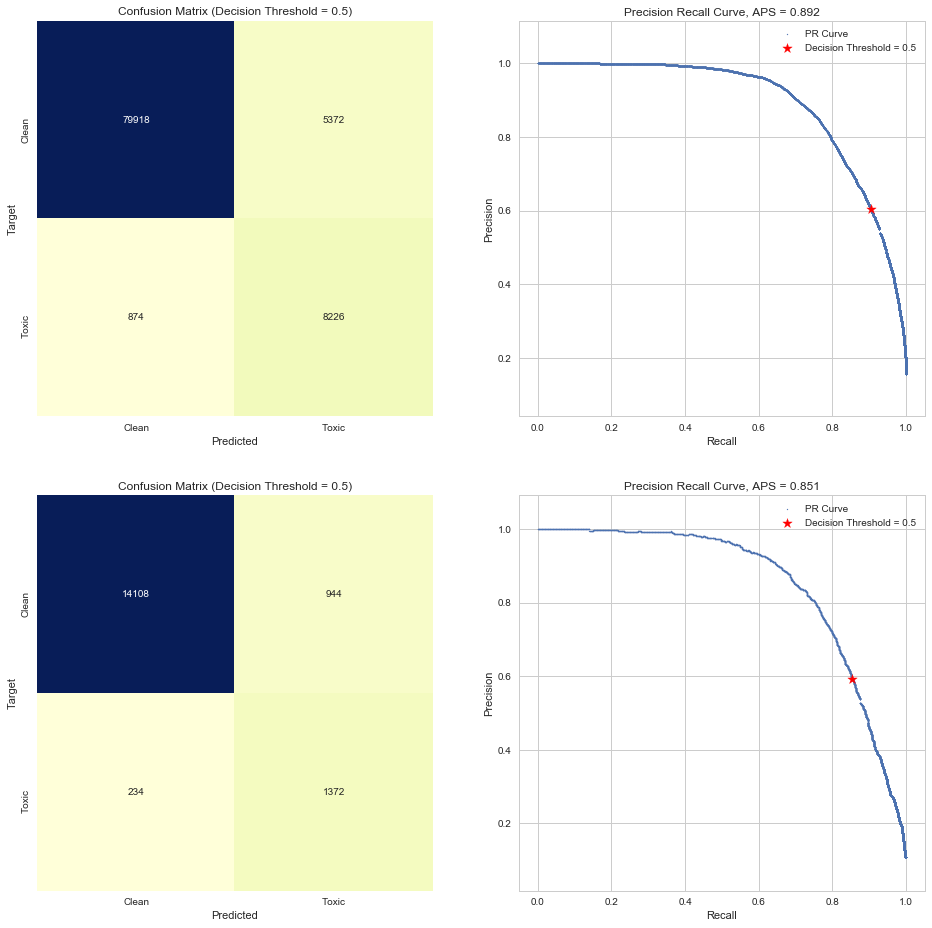

In [93]:
f, ax = plt.subplots(2, 2, figsize=(16,16))
evaluate_model(X_train, y_train, lgb, ax[0])
evaluate_model(X_val, y_val, lgb, ax[1])

Not an improvement either.

# Summary
By representing all comments using bags of words, scaled using tf-idf, I was able to classify toxic comments using a naive bayes classifier, a linnear SVM and logistic regression. With no hyperparameter tuning, the linear SVM performed the best.

It's important to evaluate model performance using measure like precision and recall, since the problem is highly unbalanced. 
Average precision is a good metric to evaluate performance in unbalance scenarios like this, but unfortunately it is very costly to compute for an SVM classifier. 
My best APS score was achieved with logistic regression: 0.874.

It would be interesting to experiment with two things to improve baseline results:
* Model hyperparameters
* Different min and max values for the document frequency thresholds

However, my next step will be to experiment with a CNN classifer.